# Get Paper Info
These notebook will get the paper info for each speakers in the conference. The attributes are: Number of papers (by year), first paper year, number of citation (by year), country

In [1]:
%run setup.py

# Invited

## Load the data

In [6]:
# Append all files in Data folder as a datafrom, and add a column for the file name without the extension and folder name
df_new  = pd.read_csv(os.path.join(filepath,'factInvited_init.csv'), encoding='utf-8')
# df_base  = pd.read_csv(os.path.join(filepath,'factInvited.csv'), encoding='utf-8')

# Find new names
# df_new = df_new[~df_new['Full name'].isin(df_base['Full name'])].reset_index(drop=True)

dblp_name = df_new['Full name'].str.replace(' ', '%20')
dblp_name = dblp_name.drop_duplicates().reset_index(drop=True)

# drop nan values from the list
dblp_name = dblp_name.dropna().reset_index(drop=True)

## Get data from dblp.org

In [8]:
df1 = pd.DataFrame(columns = ['Full name','Year','Year Count'])

for Author in tqdm(dblp_name):
    author_list = []
    paper_list = []
    
    ##### Check if author is on dblp #####
    dblp_URL = "https://dblp.org/search?q=" + Author
    page = requests.get(dblp_URL)
    soup = BeautifulSoup(page.content, "html.parser")
    control_check = soup.find(id="completesearch-authors").find_all("ul",class_ = "result-list")
    if len(control_check) > 0:
        first_author = soup.find(id="completesearch-authors").find_all("ul",class_ = "result-list")[0].find_all("a",href=True)[0]['href']
        # print(Author," is on the webpage and the process continues...")
        
        ##### Get info from author #####
        author_page = requests.get(first_author)
        soup_of_speaker = BeautifulSoup(author_page.content, "html.parser")

        Year_list = []

        sections = soup_of_speaker.find(id="publ-section").find_all("div", class_="hide-body")
        for s in range(0,len(sections)): # Nu går vi ind på hver enkelt sektion
            rows_in_sections = sections[s].find_all('ul', class_="publ-list")[0].findAll(True, {"class":['year','entry inproceedings toc','entry article toc','entry incollection toc', 'entry book toc','entry editor toc','entry reference toc']})
            last_row_idx = 0
            
            for row in range(0,len(rows_in_sections)): # Nu går vi ind på hver enkelt række
                #### Append year multipliers
                if rows_in_sections[row].p == None:
                    Year_list.append(rows_in_sections[row].text)
                    paper_list.append(row-last_row_idx-1)
                    last_row_idx = row 
                if row == len(rows_in_sections)-1: # den sidste linje i hver sektion
                    paper_list.append(len(rows_in_sections)-last_row_idx-1)
            
            # remove all -1 values from the list
            paper_list = [x for x in paper_list if x >= 0]
                
        # create a dataframe
        df2 = pd.DataFrame(columns = ['Full name','Year','Year Count'])
        # append full name to the dataframe
        
        df2['Year'] = Year_list
        df2['Year Count'] = paper_list
        df2['Full name'] = Author
        df1 = df1.append(df2, ignore_index=True)
    time.sleep(1)
        

100%|██████████| 1134/1134 [1:03:42<00:00,  3.37s/it]


In [9]:
df1.to_csv(os.path.join(filepath,"paper_count_Invited_new.csv"), index=False)
df3 = df1.copy()

## Combine data and save as factTable

In [10]:
# Load the initial factTable
df  = pd.read_csv(os.path.join(filepath,'factInvited_init.csv'), encoding='utf-8')
# Load the table with paper count per year
# df2 = pd.read_csv(os.path.join(filepath,'paper_count_per_year_proceedings.csv'), encoding='utf-8')
# concat df1 and df2
# df1 = pd.concat([df2,df3], axis=0, ignore_index=True)

In [11]:
df1['Full name'] = df1['Full name'].str.replace('%20', ' ')
df1 = df1.drop_duplicates().reset_index(drop=True)
df1['Year'] = df1['Year'].astype(int)
df1['Year Count'] = df1['Year Count'].astype(int)

df1 = df1.sort_values(by=['Year'], ascending=True)

df1['Year Count'] = df1.groupby('Full name')['Year Count'].cumsum()

df1['max_year_count'] = df1.groupby('Full name')['Year Count'].transform('max')
df1['First year paper'] = df1.groupby('Full name')['Year'].transform('min')

In [12]:
# create a function to get the paper count for a given name and year
def get_paper_count(name, year):
    df = df1[df1['Full name'] == name]
    paper_count = df[df['Year'] <= year]['Year Count']
    if len(paper_count) == 0:
        return 0
    return paper_count.iloc[-1]

# merge the dataframes and add a new column with the paper count
merged = pd.merge(df, df1.drop_duplicates(subset=['Full name']), on='Full name', how='left')
merged['Year Count'] = merged.apply(lambda x: get_paper_count(x['Full name'], x['Year_x']), axis=1)

# Clean up and control check
print("Number of rows in original table:",df.shape[0], " and umber of rows in merged table:",merged.shape[0])
print("Pct. of speakers whose information I was able to collect",round(((df['Full name'].nunique()-df[~df['Full name'].isin(df1['Full name'])].shape[0])/df1['Full name'].nunique())*100,2),"%")
merged['max_year_count'] = merged['max_year_count'].fillna(0)
merged['First year paper'] = merged['First year paper'].fillna(0)
merged = merged.drop(columns=['Year_y'])
merged = merged.rename(columns={'Year_x': 'Year', 'Year Count': 'Paper Count', 'max_year_count': 'Max Paper Count'})
merged.to_csv(os.path.join(filepath, "factInvited.csv"), index=False)
print("The file is now saved")
merged.head(10)

Number of rows in original table: 1343  and umber of rows in merged table: 1343
Pct. of speakers whose information I was able to collect 99.62 %
The file is now saved


,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper
0,Glovanni De WIichcli,2003,ASPDAC,Glovanni,De,WIichcli,M,0,0.0,0.0
1,Tadahiro Ohm,2003,ASPDAC,Tadahiro,NaN,Ohm,M,27,92.0,1993.0
2,Ycrvant Zorian,2003,ASPDAC,Ycrvant,NaN,Zorian,M,0,0.0,0.0
3,Gary L. Baldwi,2004,ASPDAC,Gary,L.,Baldwi,M,4,4.0,1962.0
4,Rudy Lauwereins,2004,ASPDAC,Rudy,NaN,Lauwereins,M,112,196.0,1987.0
5,Rajeev Madhavan,2005,ASPDAC,Rajeev,NaN,Madhavan,M,5,5.0,1994.0
6,Jan M. Rabaey,2005,ASPDAC,Jan,M.,Rabaey,M,146,321.0,1985.0
7,Zhenghua Jiang,2005,ASPDAC,Zhenghua,NaN,Jiang,M,1,1.0,2005.0
8,Alberto Sangiovanni-Vincentelli,2006,ASPDAC,Alberto,NaN,Sangiovanni-Vincentelli,M,458,691.0,1973.0
9,Satoru Ito,2006,ASPDAC,Satoru,NaN,Ito,M,3,3.0,2000.0


In [85]:
merged['Conference (short)'].unique()

array(['ASPDAC', 'CHI', 'ECCV', 'HiPC', 'ic2s2', 'ICML', 'IJCAI', 'KDD',
       'LICS', 'RTA', 'SC', 'SIGGRAPH', 'SODA', 'STOC', 'SWAT', 'WADS',
       'WoLLIC', 'WWW', 'AAAI'], dtype=object)

# Proceedings

## Load the data

In [105]:
df  = pd.read_csv(os.path.join(filepath,'factProceedings_init.csv'), encoding='utf-8')

In [186]:
df  = pd.read_csv(os.path.join(filepath,'factProceedings_init.csv'), encoding='utf-8')
# remove [' '] from the string in Links column
df['Links'] = df['Links'].str.replace("[","")
df['Links'] = df['Links'].str.replace("']","")
df['Links'] = df['Links'].str.replace("'","")
df['Links'] = df['Links'].str.replace(".html","")

dblp_name = df['Full name'].unique()
df.head()

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender
0,Hiroto Yasuura,2003,https://dblp.org/pid/43/4149,ASPDAC,Hiroto,NaN,Yasuura,M
1,Farzan Fallah,2003,https://dblp.org/pid/02/1886,ASPDAC,Farzan,NaN,Fallah,M
2,Satoshi Komatsu,2003,https://dblp.org/pid/08/4585,ASPDAC,Satoshi,NaN,Komatsu,M
3,Masahiro Fujita,2003,https://dblp.org/pid/56/1768,ASPDAC,Masahiro,NaN,Fujita,M
4,Sri Parameswaran,2003,https://dblp.org/pid/38/622,ASPDAC,Sri,NaN,Parameswaran,F


In [28]:
# drop all nan values from dblp_name
dblp_name[8863]

nan

In [187]:
dblp_name = [x for x in dblp_name if str(x) != 'nan']

In [43]:
df1 = pd.DataFrame(columns = ['Full name','New_Link'])
new_link = []
author = []

for Author in tqdm(dblp_name[0:8863]):
    ##### Check if author is on dblp #####
    dblp_URL = "https://dblp.org/search?q=" + Author
    page = requests.get(dblp_URL)
    soup = BeautifulSoup(page.content, "html.parser")
    control_check = soup.find(id="completesearch-authors").find_all("ul",class_ = "result-list")
    if len(control_check) > 0:
        first_author = soup.find(id="completesearch-authors").find_all("ul",class_ = "result-list")[0].find_all("a",href=True)[0]['href']
        author.append(Author)
        new_link.append(first_author)
    time.sleep(3)

df1['Full name'] = author
df1['New_Link'] = new_link

100%|██████████| 8863/8863 [8:03:21<00:00,  3.27s/it]  


In [44]:
df1.head()

,Full name,New_Link
0,Hiroto Yasuura,https://dblp.org/pid/43/4149
1,Farzan Fallah,https://dblp.org/pid/02/1886
2,Satoshi Komatsu,https://dblp.org/pid/08/4585
3,Masahiro Fujita,https://dblp.org/pid/56/1768
4,Sri Parameswaran,https://dblp.org/pid/38/622


In [45]:
# 0:8863
new_link1 = new_link.copy()
author1 = author.copy()

In [38]:
# 8863:30000
new_link6 = new_link.copy()
author6 = author.copy()

In [46]:
df4 = pd.DataFrame(columns = ['Full name','New_Link'])
df4['Full name'] = author1 + author6
df4['New_Link'] = new_link1 + new_link6

In [47]:
df4.head()

,Full name,New_Link
0,Hiroto Yasuura,https://dblp.org/pid/43/4149
1,Farzan Fallah,https://dblp.org/pid/02/1886
2,Satoshi Komatsu,https://dblp.org/pid/08/4585
3,Masahiro Fujita,https://dblp.org/pid/56/1768
4,Sri Parameswaran,https://dblp.org/pid/38/622


In [48]:
# df4.to_csv(os.path.join(filepath,"new_link_0_30000.csv"), index=False)

In [195]:
df4_1 = pd.read_csv(os.path.join(filepath,"new_link_30000_67000.csv"), encoding='utf-8')
df4_2 = pd.read_csv(os.path.join(filepath,"new_link_0_30000.csv"), encoding='utf-8')
df4 = pd.concat([df4_1,df4_2], axis=0, ignore_index=True)

In [190]:
df = df[~df['Links'].isna()]

In [201]:
df5 = df.merge(df4, on='Full name', how='left')

In [202]:
names = list(dblp_name)

In [203]:
df6 = df5[df5['Full name'].isin(names)]

In [204]:
df6['column_equal'] = df6['New_Link'] == df6['Links']

In [207]:
df6 = df6[df6['column_equal'] == False]

In [208]:
df7 = df6.drop_duplicates(subset=['Links','Full name'])

In [209]:
df7

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal
14,Gang Qu,2003,https://dblp.org/pid/04/3130,ASPDAC,Gang,NaN,Qu,M,https://dblp.org/pid/308/6751,False
16,Yumin Zhang,2003,https://dblp.org/pid/66/294,ASPDAC,Yumin,NaN,Zhang,M,https://dblp.org/pid/150/7068,False
26,Alexander Smith,2003,https://dblp.org/pid/75/3840-1,ASPDAC,Alexander,NaN,Smith,M,https://dblp.org/pid/115/9177,False
32,Rajesh K. Gupta,2003,https://dblp.org/pid/213/9138-1,ASPDAC,Rajesh,K.,Gupta,M,https://dblp.org/pid/213/9138,False
50,Kaushik Roy,2003,https://dblp.org/pid/r/KaushikRoy,ASPDAC,Kaushik,NaN,Roy,M,https://dblp.org/pid/183/5157,False
...,...,...,...,...,...,...,...,...,...,...
179027,Dirk van der,2019,https://dblp.org/pid/215/5065,NeurIPS,Dirk,van,der,M,https://dblp.org/pid/116/4950,False
179188,Nicolas Perrin,2019,https://dblp.org/pid/37/1452,NeurIPS,Nicolas,NaN,Perrin,M,https://dblp.org/pid/37/1452-2,False
179315,Peng Chen,2019,https://dblp.org/pid/27/7017-24,NeurIPS,Peng,NaN,Chen,M,https://dblp.org/pid/27/7017,False
179366,Yiming Ding,2019,https://dblp.org/pid/49/9829,NeurIPS,Yiming,NaN,Ding,M,https://dblp.org/pid/273/6876,False


In [61]:
df8 = df7.copy()

In [125]:
df1 = pd.DataFrame(columns = ['Full name','Year','Year Count','Links'])

for index, rows in tqdm(df7[908:].iterrows()):
    author_list = []
    paper_list = []
    
    first_author = rows['Links']
    # print(Author," is on the webpage and the process continues...")
    
    ##### Get info from author #####
    author_page = requests.get(first_author)
    soup_of_speaker = BeautifulSoup(author_page.content, "html.parser")

    Year_list = []

    sections = soup_of_speaker.find(id="publ-section").find_all("div", class_="hide-body")
    for s in range(0,len(sections)): # Nu går vi ind på hver enkelt sektion
        rows_in_sections = sections[s].find_all('ul', class_="publ-list")[0].findAll(True, {"class":['year','entry inproceedings toc','entry article toc','entry incollection toc', 'entry book toc','entry editor toc','entry reference toc']})
        last_row_idx = 0
        
        for row in range(0,len(rows_in_sections)): # Nu går vi ind på hver enkelt række
            #### Append year multipliers
            if rows_in_sections[row].p == None:
                Year_list.append(rows_in_sections[row].text)
                paper_list.append(row-last_row_idx-1)
                last_row_idx = row 
            if row == len(rows_in_sections)-1: # den sidste linje i hver sektion
                paper_list.append(len(rows_in_sections)-last_row_idx-1)
        
        # remove all -1 values from the list
        paper_list = [x for x in paper_list if x >= 0]
            
    # create a dataframe
    df2 = pd.DataFrame(columns = ['Full name','Year','Year Count'])
    # append full name to the dataframe
    
    df2['Year'] = Year_list
    df2['Year Count'] = paper_list
    df2['Full name'] = rows['Full name']
    df2['Links'] = rows['Links']
    df1 = df1.append(df2, ignore_index=True)
    time.sleep(2)
        

1450it [1:11:30,  2.96s/it]


In [128]:
# df1.to_csv(os.path.join(filepath,"paper_count_30000_67000.csv"), index=False, encoding='utf-8')

In [123]:
# 
df3 = df1.copy()

In [126]:
df4 = df1.copy()

In [76]:
df5 = df1.copy()

In [127]:
df1 = pd.concat([df3,df4], ignore_index=True)

In [78]:
len(df6)

42990

In [210]:
df1_1 = pd.read_csv(os.path.join(filepath,"paper_count_30000_67000.csv"), encoding='utf-8')
df1_2 = pd.read_csv(os.path.join(filepath,"paper_count_0_30000.csv"), encoding='utf-8')
df1 = pd.concat([df1_1,df1_2], axis=0, ignore_index=True)

In [185]:
df1

,Full name,Year,Year Count,Links
0,Weiwei Shen,2021,1,https://dblp.org/pid/79/1497
1,Weiwei Shen,2019,3,https://dblp.org/pid/79/1497
2,Weiwei Shen,2018,3,https://dblp.org/pid/79/1497
3,Weiwei Shen,2017,6,https://dblp.org/pid/79/1497
4,Weiwei Shen,2016,3,https://dblp.org/pid/79/1497
...,...,...,...,...
24669,Yiming Ding,2011,0,https://dblp.org/pid/49/9829
24670,Lei Chen,2022,0,https://dblp.org/pid/09/3666-62
24671,Lei Chen,2021,2,https://dblp.org/pid/09/3666-62
24672,Lei Chen,2020,1,https://dblp.org/pid/09/3666-62


In [80]:
df1 = df6.copy()

In [211]:
# df1['Full name'] = df1['Full name'].str.replace('%20', ' ')
df1 = df1.drop_duplicates().reset_index(drop=True)
df1['Year'] = df1['Year'].astype(int)
df1['Year Count'] = df1['Year Count'].astype(int)

df1 = df1.sort_values(by=['Links','Year'], ascending=True)

df1['Year Count'] = df1.groupby('Links')['Year Count'].cumsum()

df1['max_year_count'] = df1.groupby('Links')['Year Count'].transform('max')
df1['First year paper'] = df1.groupby('Links')['Year'].transform('min')
df1.head()

,Full name,Year,Year Count,Links,max_year_count,First year paper
48042,Yanping Huang,2011,1,https://dblp.org/pid/00/10104,20,2011
48041,Yanping Huang,2012,2,https://dblp.org/pid/00/10104,20,2011
48040,Yanping Huang,2014,3,https://dblp.org/pid/00/10104,20,2011
48039,Yanping Huang,2015,4,https://dblp.org/pid/00/10104,20,2011
48038,Yanping Huang,2016,5,https://dblp.org/pid/00/10104,20,2011


In [232]:
df1[df1['Full name'] == "Yanping Huang"]

,Full name,Year,Year Count,Links,max_year_count,First year paper
48042,Yanping Huang,2011,1,https://dblp.org/pid/00/10104,20,2011
48041,Yanping Huang,2012,2,https://dblp.org/pid/00/10104,20,2011
48040,Yanping Huang,2014,3,https://dblp.org/pid/00/10104,20,2011
48039,Yanping Huang,2015,4,https://dblp.org/pid/00/10104,20,2011
48038,Yanping Huang,2016,5,https://dblp.org/pid/00/10104,20,2011
48037,Yanping Huang,2018,7,https://dblp.org/pid/00/10104,20,2011
48036,Yanping Huang,2019,9,https://dblp.org/pid/00/10104,20,2011
48035,Yanping Huang,2020,10,https://dblp.org/pid/00/10104,20,2011
48034,Yanping Huang,2021,14,https://dblp.org/pid/00/10104,20,2011
48033,Yanping Huang,2022,19,https://dblp.org/pid/00/10104,20,2011


In [230]:
df[df['Full name'] == 'Yanping Huang']['Links']

56700     https://dblp.org/pid/00/10104
144843    https://dblp.org/pid/00/10104
165840    https://dblp.org/pid/00/10104
167801    https://dblp.org/pid/00/10104
175569    https://dblp.org/pid/00/10104
Name: Links, dtype: object

In [234]:
merged[merged['Full name_x'] == 'Yanping Huang']

,Full name_x,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal,Full name_y,Paper Count,Max Paper Count,First year paper
4616,Yanping Huang,2022,https://dblp.org/pid/00/10104,ICML,Yanping,NaN,Huang,F,https://dblp.org/pid/47/6512,False,Yanping Huang,19,20.0,2011.0
17551,Yanping Huang,2019,https://dblp.org/pid/00/10104,AAAI,Yanping,NaN,Huang,F,https://dblp.org/pid/47/6512,False,Yanping Huang,9,20.0,2011.0
21356,Yanping Huang,2012,https://dblp.org/pid/00/10104,NeurIPS,Yanping,NaN,Huang,F,https://dblp.org/pid/47/6512,False,Yanping Huang,2,20.0,2011.0
21520,Yanping Huang,2014,https://dblp.org/pid/00/10104,NeurIPS,Yanping,NaN,Huang,F,https://dblp.org/pid/47/6512,False,Yanping Huang,3,20.0,2011.0
22295,Yanping Huang,2019,https://dblp.org/pid/00/10104,NeurIPS,Yanping,NaN,Huang,F,https://dblp.org/pid/47/6512,False,Yanping Huang,9,20.0,2011.0


In [212]:
df = df6.copy()

In [233]:
# create a function to get the paper count for a given name and year
def get_paper_count(name, year):
    df = df1[df1['Links'] == name]
    paper_count = df[df['Year'] <= year]['Year Count']
    if len(paper_count) == 0:
        return 0
    return paper_count.iloc[-1]

# merge the dataframes and add a new column with the paper count
merged = pd.merge(df, df1.drop_duplicates(subset=['Links']), on='Links', how='left')
merged['Year Count'] = merged.apply(lambda x: get_paper_count(x['Links'], x['Year_x']), axis=1)

# Clean up and control check
merged['max_year_count'] = merged['max_year_count'].fillna(0)
merged['First year paper'] = merged['First year paper'].fillna(0)
merged = merged.drop(columns=['Year_y'])
merged = merged.rename(columns={'Year_x': 'Year', 'Year Count': 'Paper Count', 'max_year_count': 'Max Paper Count'})


In [289]:
weird_links = ["https://dblp.org/pid/10/4661","https://dblp.org/pid/g/WenGao",'https://dblp.org/pid/125/8189','https://dblp.org/pid/h/JiaweiHan',"https://dblp.org/pid/53/2189",'https://dblp.org/pid/37/4190','https://dblp.org/pid/48/450','https://dblp.org/pid/13/6769','https://dblp.org/pid/06/6785','https://dblp.org/pid/w/JieWu1','https://dblp.org/pid/33/5448']
merged = merged[~merged['Links'].isin(weird_links)]
merged['Paper Count'].sort_values(ascending=False)[:20]

20653    746
20705    746
970      727
20416    725
14716    725
20354    725
4477     703
20309    697
20437    697
19606    658
4497     658
10928    658
19212    658
18134    650
11210    648
9943     644
10553    624
17900    620
1027     620
20626    620
Name: Paper Count, dtype: int64

In [302]:
merged = merged.drop(['Full name_y'], axis=1)

In [303]:
# merged.to_csv(os.path.join(filepath,"proceedings_init_with_merged_data_ALL.csv"), index=False, encoding='utf-8')

In [134]:
# merged.to_csv(os.path.join(filepath,"proceedings_init_with_merged_data_30000__.csv"), index=False, encoding='utf-8')

In [133]:
merged

,Full name_x,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal,Full name_y,Paper Count,Max Paper Count,First year paper
0,Weiwei Shen,2015,https://dblp.org/pid/79/1497,IJCAI,Weiwei,NaN,Shen,F,https://dblp.org/pid/178/7727,False,Weiwei Shen,0,28.0,2005.0
1,Ke Tang,2015,https://dblp.org/pid/50/3146-1,IJCAI,Ke,NaN,Tang,M,https://dblp.org/pid/50/3146,False,Ke Tang,0,225.0,2007.0
2,Jiajun Zhang,2015,https://dblp.org/pid/71/6950-1,IJCAI,Jiajun,NaN,Zhang,M,https://dblp.org/pid/71/6950-7,False,Jiajun Zhang,0,117.0,2008.0
3,Yifei Lu,2015,https://dblp.org/pid/79/3426,IJCAI,Yifei,NaN,Lu,M,https://dblp.org/pid/290/4738,False,Yifei Lu,0,39.0,2008.0
4,Binbin Li,2015,https://dblp.org/pid/06/8137,IJCAI,Binbin,NaN,Li,F,https://dblp.org/pid/70/631,False,Binbin Li,0,119.0,2009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5310,Nicolas Perrin,2019,https://dblp.org/pid/37/1452,NeurIPS,Nicolas,NaN,Perrin,M,https://dblp.org/pid/37/1452-2,False,Nicolas Perrin,0,33.0,2007.0
5311,Yingying Li,2019,https://dblp.org/pid/63/5869,NeurIPS,Yingying,NaN,Li,F,https://dblp.org/pid/224/0265,False,Yingying Li,0,105.0,2002.0
5312,Stephen Giguere,2019,https://dblp.org/pid/14/8174,NeurIPS,Stephen,NaN,Giguere,M,https://dblp.org/pid/315/0810,False,Stephen Giguere,0,7.0,2013.0
5313,Yiming Ding,2019,https://dblp.org/pid/49/9829,NeurIPS,Yiming,NaN,Ding,M,https://dblp.org/pid/273/6876,False,Yiming Ding,0,18.0,2011.0


# Okay okay okay
Nu har jeg alle dem er wirdoes, og skal sætte det sammen med alle de andre

In [2]:
df_init  = pd.read_csv(os.path.join(filepath,'factProceedings_init.csv'), encoding='utf-8')
# remove [' '] from the string in Links column
df_init['Links'] = df_init['Links'].str.replace("[","")
df_init['Links'] = df_init['Links'].str.replace("']","")
df_init['Links'] = df_init['Links'].str.replace("'","")
df_init['Links'] = df_init['Links'].str.replace(".html","")

dblp_name = df_init['Full name'].unique()
df_init.head()

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender
0,Hiroto Yasuura,2003,https://dblp.org/pid/43/4149,ASPDAC,Hiroto,NaN,Yasuura,M
1,Farzan Fallah,2003,https://dblp.org/pid/02/1886,ASPDAC,Farzan,NaN,Fallah,M
2,Satoshi Komatsu,2003,https://dblp.org/pid/08/4585,ASPDAC,Satoshi,NaN,Komatsu,M
3,Masahiro Fujita,2003,https://dblp.org/pid/56/1768,ASPDAC,Masahiro,NaN,Fujita,M
4,Sri Parameswaran,2003,https://dblp.org/pid/38/622,ASPDAC,Sri,NaN,Parameswaran,F


In [3]:
df1 = pd.read_csv(os.path.join(filepath,"new_link_0_30000.csv"), encoding='utf-8')
df2 = pd.read_csv(os.path.join(filepath,"new_link_30000_67000.csv"), encoding='utf-8')
df3 = pd.concat([df1,df2], ignore_index=True)
df_init = df_init.merge(df3, on='Full name', how='left')
df_init

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link
0,Hiroto Yasuura,2003,https://dblp.org/pid/43/4149,ASPDAC,Hiroto,NaN,Yasuura,M,https://dblp.org/pid/43/4149
1,Farzan Fallah,2003,https://dblp.org/pid/02/1886,ASPDAC,Farzan,NaN,Fallah,M,https://dblp.org/pid/02/1886
2,Satoshi Komatsu,2003,https://dblp.org/pid/08/4585,ASPDAC,Satoshi,NaN,Komatsu,M,https://dblp.org/pid/08/4585
3,Masahiro Fujita,2003,https://dblp.org/pid/56/1768,ASPDAC,Masahiro,NaN,Fujita,M,https://dblp.org/pid/56/1768
4,Sri Parameswaran,2003,https://dblp.org/pid/38/622,ASPDAC,Sri,NaN,Parameswaran,F,https://dblp.org/pid/38/622
...,...,...,...,...,...,...,...,...,...
202081,Margret Keuper,2022,NaN,NeurIPS,Margret,NaN,Keuper,F,https://dblp.org/pid/95/7589
202082,Gabriele Farina,2022,NaN,NeurIPS,Gabriele,NaN,Farina,F,https://dblp.org/pid/159/2090
202083,Ioannis Anagnostides,2022,NaN,NeurIPS,Ioannis,NaN,Anagnostides,M,https://dblp.org/pid/273/7648
202084,Christian Kroer,2022,NaN,NeurIPS,Christian,NaN,Kroer,M,https://dblp.org/pid/64/10660


In [4]:
df_init['column_equal'] = df_init['Links'] == df_init['New_Link']
df_init = df_init[(df_init['column_equal'] == True) | (df_init['Links'].isna())]

In [5]:
df_init

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal
0,Hiroto Yasuura,2003,https://dblp.org/pid/43/4149,ASPDAC,Hiroto,NaN,Yasuura,M,https://dblp.org/pid/43/4149,True
1,Farzan Fallah,2003,https://dblp.org/pid/02/1886,ASPDAC,Farzan,NaN,Fallah,M,https://dblp.org/pid/02/1886,True
2,Satoshi Komatsu,2003,https://dblp.org/pid/08/4585,ASPDAC,Satoshi,NaN,Komatsu,M,https://dblp.org/pid/08/4585,True
3,Masahiro Fujita,2003,https://dblp.org/pid/56/1768,ASPDAC,Masahiro,NaN,Fujita,M,https://dblp.org/pid/56/1768,True
4,Sri Parameswaran,2003,https://dblp.org/pid/38/622,ASPDAC,Sri,NaN,Parameswaran,F,https://dblp.org/pid/38/622,True
...,...,...,...,...,...,...,...,...,...,...
202081,Margret Keuper,2022,NaN,NeurIPS,Margret,NaN,Keuper,F,https://dblp.org/pid/95/7589,False
202082,Gabriele Farina,2022,NaN,NeurIPS,Gabriele,NaN,Farina,F,https://dblp.org/pid/159/2090,False
202083,Ioannis Anagnostides,2022,NaN,NeurIPS,Ioannis,NaN,Anagnostides,M,https://dblp.org/pid/273/7648,False
202084,Christian Kroer,2022,NaN,NeurIPS,Christian,NaN,Kroer,M,https://dblp.org/pid/64/10660,False


In [6]:
df_pro  = pd.read_csv(os.path.join(filepath,'factProceedings.csv'), encoding='utf-8')
df_pro = df_pro[['Full name','Year','Conference (short)','Paper Count','gender','Max Paper Count','First year paper']]
df_pro = df_pro.drop_duplicates(subset= ['Full name','Year','Conference (short)']).reset_index(drop=True)

In [7]:
df_pro

,Full name,Year,Conference (short),Paper Count,gender,Max Paper Count,First year paper
0,Aaron Gage,2004,AAAI,7,M,8,1999
1,Abhi Shelat,2004,AAAI,7,M,75,2002
2,Adele E. Howe,2004,AAAI,48,F,91,1986
3,Akihiro Kishimoto,2004,AAAI,4,M,62,2002
4,Al Globus,2004,AAAI,6,M,6,1990
...,...,...,...,...,...,...,...
178526,Tiziano Dalmonte,2022,WoLLIC,15,M,15,2018
178527,Tomas Svoboda,2022,WoLLIC,47,M,49,1997
178528,Tomoyuki Yamakami,2022,WoLLIC,98,M,98,1992
178529,Valentin Cassano,2022,WoLLIC,13,M,13,2013


In [8]:
print(df_init.shape)
print(df_pro.shape)

(179342, 10)
(178531, 7)


In [9]:
Proceedings = df_init.merge(df_pro, on=['Full name','Year','Conference (short)','gender'], how='left')
Proceedings

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal,Paper Count,Max Paper Count,First year paper
0,Hiroto Yasuura,2003,https://dblp.org/pid/43/4149,ASPDAC,Hiroto,NaN,Yasuura,M,https://dblp.org/pid/43/4149,True,71.0,115.0,1981.0
1,Farzan Fallah,2003,https://dblp.org/pid/02/1886,ASPDAC,Farzan,NaN,Fallah,M,https://dblp.org/pid/02/1886,True,25.0,57.0,1998.0
2,Satoshi Komatsu,2003,https://dblp.org/pid/08/4585,ASPDAC,Satoshi,NaN,Komatsu,M,https://dblp.org/pid/08/4585,True,10.0,51.0,1998.0
3,Masahiro Fujita,2003,https://dblp.org/pid/56/1768,ASPDAC,Masahiro,NaN,Fujita,M,https://dblp.org/pid/56/1768,True,147.0,473.0,1983.0
4,Sri Parameswaran,2003,https://dblp.org/pid/38/622,ASPDAC,Sri,NaN,Parameswaran,F,https://dblp.org/pid/38/622,True,21.0,208.0,1994.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179337,Margret Keuper,2022,NaN,NeurIPS,Margret,NaN,Keuper,F,https://dblp.org/pid/95/7589,False,49.0,52.0,2009.0
179338,Gabriele Farina,2022,NaN,NeurIPS,Gabriele,NaN,Farina,F,https://dblp.org/pid/159/2090,False,44.0,44.0,2015.0
179339,Ioannis Anagnostides,2022,NaN,NeurIPS,Ioannis,NaN,Anagnostides,M,https://dblp.org/pid/273/7648,False,12.0,12.0,2020.0
179340,Christian Kroer,2022,NaN,NeurIPS,Christian,NaN,Kroer,M,https://dblp.org/pid/64/10660,False,57.0,57.0,2011.0


In [10]:
df_new  = pd.read_csv(os.path.join(filepath,'proceedings_init_with_merged_data_ALL.csv'), encoding='utf-8')
df_new = df_new.rename(columns={'Full name_x': 'Full name'})
df_new

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal,Paper Count,Max Paper Count,First year paper
0,Gang Qu,2003,https://dblp.org/pid/04/3130,ASPDAC,Gang,NaN,Qu,M,https://dblp.org/pid/308/6751,False,40,266.0,1998.0
1,Yumin Zhang,2003,https://dblp.org/pid/66/294,ASPDAC,Yumin,NaN,Zhang,M,https://dblp.org/pid/150/7068,False,12,40.0,1999.0
2,Alexander Smith,2003,https://dblp.org/pid/75/3840-1,ASPDAC,Alexander,NaN,Smith,M,https://dblp.org/pid/115/9177,False,1,5.0,2003.0
3,Rajesh K. Gupta,2003,https://dblp.org/pid/213/9138-1,ASPDAC,Rajesh,K.,Gupta,M,https://dblp.org/pid/213/9138,False,212,648.0,1990.0
4,Kaushik Roy,2003,https://dblp.org/pid/r/KaushikRoy,ASPDAC,Kaushik,NaN,Roy,M,https://dblp.org/pid/183/5157,False,189,748.0,1988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22458,Hoang Minh Le,2019,https://dblp.org/pid/10/1634-2,NeurIPS,Hoang,Minh,Le,M,https://dblp.org/pid/10/1634-1,False,8,9.0,2016.0
22459,Ke Li,2019,https://dblp.org/pid/75/6627-11,NeurIPS,Ke,NaN,Li,M,https://dblp.org/pid/75/6627,False,9,12.0,2015.0
22460,Lei Chen,2019,https://dblp.org/pid/09/3666-62,NeurIPS,Lei,NaN,Chen,F,https://dblp.org/pid/09/3666,False,2,5.0,2019.0
22461,Ping Li,2019,https://dblp.org/pid/62/5860-1,NeurIPS,Ping,NaN,Li,F,https://dblp.org/pid/62/5860,False,129,285.0,2005.0


In [11]:
Proceedings = pd.concat([Proceedings, df_new], axis=0, ignore_index=True)

In [12]:
Proceedings

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal,Paper Count,Max Paper Count,First year paper
0,Hiroto Yasuura,2003,https://dblp.org/pid/43/4149,ASPDAC,Hiroto,NaN,Yasuura,M,https://dblp.org/pid/43/4149,True,71.0,115.0,1981.0
1,Farzan Fallah,2003,https://dblp.org/pid/02/1886,ASPDAC,Farzan,NaN,Fallah,M,https://dblp.org/pid/02/1886,True,25.0,57.0,1998.0
2,Satoshi Komatsu,2003,https://dblp.org/pid/08/4585,ASPDAC,Satoshi,NaN,Komatsu,M,https://dblp.org/pid/08/4585,True,10.0,51.0,1998.0
3,Masahiro Fujita,2003,https://dblp.org/pid/56/1768,ASPDAC,Masahiro,NaN,Fujita,M,https://dblp.org/pid/56/1768,True,147.0,473.0,1983.0
4,Sri Parameswaran,2003,https://dblp.org/pid/38/622,ASPDAC,Sri,NaN,Parameswaran,F,https://dblp.org/pid/38/622,True,21.0,208.0,1994.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
201800,Hoang Minh Le,2019,https://dblp.org/pid/10/1634-2,NeurIPS,Hoang,Minh,Le,M,https://dblp.org/pid/10/1634-1,False,8.0,9.0,2016.0
201801,Ke Li,2019,https://dblp.org/pid/75/6627-11,NeurIPS,Ke,NaN,Li,M,https://dblp.org/pid/75/6627,False,9.0,12.0,2015.0
201802,Lei Chen,2019,https://dblp.org/pid/09/3666-62,NeurIPS,Lei,NaN,Chen,F,https://dblp.org/pid/09/3666,False,2.0,5.0,2019.0
201803,Ping Li,2019,https://dblp.org/pid/62/5860-1,NeurIPS,Ping,NaN,Li,F,https://dblp.org/pid/62/5860,False,129.0,285.0,2005.0


## Remove weird/wrong rows

In [79]:
check_links_list = list(Proceedings[Proceedings['Paper Count'] >= 300]['Links'].unique())

In [80]:
# drop nan values in check_links_list
check_links_list = [x for x in check_links_list if str(x) != 'nan']
print(len(check_links_list))
check_links_list_BU = check_links_list.copy()

759


In [49]:
i = -1
remove_idx = []
for weird_link in tqdm(check_links_list):
    i += 1
    page = requests.get(weird_link)
    soup = BeautifulSoup(page.content, "html.parser")
    if soup.find_all("div", {"class": "remark-box"}):
        remove_idx.append(i)
    time.sleep(2)

100%|██████████| 759/759 [3:47:18<00:00, 17.97s/it]   


In [69]:
print('Number of links to be removed',len(remove_idx))

Number of links to be removed 308


In [55]:
# save remove_idx as a csv file
with open("remove_idx.txt", "w") as file:
    # Write each element of the list to a new line in the file
    for item in remove_idx:
        file.write(str(item) + "\n")

In [84]:
remove_idx.sort(reverse=True)

for index in remove_idx:
    del check_links_list[index]
    
print(len(check_links_list))

451


In [151]:
df_below = Proceedings[Proceedings['Paper Count'] < 300]
df_above = Proceedings[(Proceedings['Paper Count'] >= 300) & Proceedings['Links'].isin(check_links_list)]

df_proceedings = pd.concat([df_below,df_above], axis=0, ignore_index=True)

In [153]:
# Give ID
df_proceedings = df_proceedings.sort_values(['Full name', 'Links'])
df_proceedings['ID'] = 0
current_name = ''
current_links = ''
count = 0

for index, row in df_proceedings.iterrows():
    if row['Full name'] != current_name:
        current_name = row['Full name']
        current_links = row['Links']
        count = 1
    elif row['Links'] != current_links:
        current_links = row['Links']
        count += 1
    df_proceedings.at[index, 'ID'] = row['Full name'] + "_" + str(count)

In [158]:
df_proceedings = df_proceedings.drop(['Links','New_Link'], axis=1)

In [159]:
df_proceedings

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID
5569,Aabid Rushdi,2022,ASPDAC,Aabid,NaN,Rushdi,M,True,1.0,1.0,2022.0,Aabid Rushdi_1
85708,Aabid Shamji,2021,SC,Aabid,NaN,Shamji,M,True,3.0,3.0,2019.0,Aabid Shamji_1
153566,Aadarsh Sahoo,2021,NeurIPS,Aadarsh,NaN,Sahoo,M,False,2.0,3.0,2020.0,Aadarsh Sahoo_1
62225,Aadesh Neupane,2019,IJCAI,Aadesh,NaN,Neupane,M,True,5.0,6.0,2017.0,Aadesh Neupane_1
128462,Aadi Swadipto Mondal,2021,AAAI,Aadi,Swadipto,Mondal,M,True,2.0,2.0,2020.0,Aadi Swadipto Mondal_1
...,...,...,...,...,...,...,...,...,...,...,...,...
89625,Zvi Lotker,2016,SODA,Zvi,NaN,Lotker,M,True,110.0,135.0,1999.0,Zvi Lotker_1
93321,Zvi Lotker,2011,STOC,Zvi,NaN,Lotker,M,True,75.0,135.0,1999.0,Zvi Lotker_1
103695,Zvi Lotker,2018,WWW,Zvi,NaN,Lotker,M,True,122.0,135.0,1999.0,Zvi Lotker_1
116684,Zvi Nisin,2017,AAAI,Zvi,NaN,Nisin,M,True,2.0,2.0,2016.0,Zvi Nisin_1


In [160]:
df_proceedings.to_csv(os.path.join(filepath,'factProceedings.csv'), encoding='utf-8', index=False)

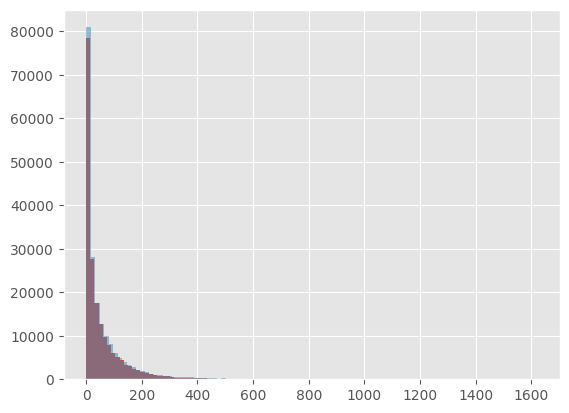

In [114]:
plt.hist(df_proceedings['Paper Count'], bins=100)
plt.hist(Proceedings['Paper Count'], bins=100, alpha=0.5)
plt.show()

In [119]:
df_new  = pd.read_csv(os.path.join(filepath,'factProceedings.csv'), encoding='utf-8')
len(df_new) - len(df_proceedings)

22542

In [579]:
df_new  = pd.read_csv(os.path.join(filepath,'proceedings_init_with_merged_data_ALL.csv'), encoding='utf-8')
df_new = df_new.rename(columns={'Full name_x': 'Full name'})
df_new

,Full name,Year,Links,Conference (short),First name,Middle name,Last name,gender,New_Link,column_equal,Paper Count,Max Paper Count,First year paper
0,Gang Qu,2003,https://dblp.org/pid/04/3130,ASPDAC,Gang,NaN,Qu,M,https://dblp.org/pid/308/6751,False,40,266.0,1998.0
1,Yumin Zhang,2003,https://dblp.org/pid/66/294,ASPDAC,Yumin,NaN,Zhang,M,https://dblp.org/pid/150/7068,False,12,40.0,1999.0
2,Alexander Smith,2003,https://dblp.org/pid/75/3840-1,ASPDAC,Alexander,NaN,Smith,M,https://dblp.org/pid/115/9177,False,1,5.0,2003.0
3,Rajesh K. Gupta,2003,https://dblp.org/pid/213/9138-1,ASPDAC,Rajesh,K.,Gupta,M,https://dblp.org/pid/213/9138,False,212,648.0,1990.0
4,Kaushik Roy,2003,https://dblp.org/pid/r/KaushikRoy,ASPDAC,Kaushik,NaN,Roy,M,https://dblp.org/pid/183/5157,False,189,748.0,1988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22458,Hoang Minh Le,2019,https://dblp.org/pid/10/1634-2,NeurIPS,Hoang,Minh,Le,M,https://dblp.org/pid/10/1634-1,False,8,9.0,2016.0
22459,Ke Li,2019,https://dblp.org/pid/75/6627-11,NeurIPS,Ke,NaN,Li,M,https://dblp.org/pid/75/6627,False,9,12.0,2015.0
22460,Lei Chen,2019,https://dblp.org/pid/09/3666-62,NeurIPS,Lei,NaN,Chen,F,https://dblp.org/pid/09/3666,False,2,5.0,2019.0
22461,Ping Li,2019,https://dblp.org/pid/62/5860-1,NeurIPS,Ping,NaN,Li,F,https://dblp.org/pid/62/5860,False,129,285.0,2005.0


In [581]:
Proceedings['Conference (short)'].unique()

array(['WoLLIC', 'ic2s2', 'NeurIPS'], dtype=object)

In [580]:
print(Proceedings.shape)
print(df_new.shape)

(21856, 13)
(22463, 13)


In [159]:
merged.shape

(5315, 14)

In [158]:
df_merged1  = pd.read_csv(os.path.join(filepath,'proceedings_init_with_merged_data_30000__.csv'), encoding='utf-8')
df_merged2  = pd.read_csv(os.path.join(filepath,'proceedings_init_with_merged_data_30000__.csv'), encoding='utf-8')

## Get data from dblp.org

Nu har jeg df_base som er min gamle df_proceedings med rigtige uft-8 navne.
Når koden under har kørt skal jeg lægge de nye data sammen med df (df_proceedings) som KUN indeholder NeurIPS data. Så merger jeg. 
Når den data frame er helt færdig skal den lægges sammen med df_base.

In [49]:
df1 = pd.DataFrame(columns = ['Full name','Year','Year Count'])

for Author in tqdm(dblp_name[0:10000]):
    author_list = []
    paper_list = []
    
    ##### Check if author is on dblp #####
    dblp_URL = "https://dblp.org/search?q=" + Author
    page = requests.get(dblp_URL)
    soup = BeautifulSoup(page.content, "html.parser")
    control_check = soup.find(id="completesearch-authors").find_all("ul",class_ = "result-list")
    if len(control_check) > 0:
        first_author = soup.find(id="completesearch-authors").find_all("ul",class_ = "result-list")[0].find_all("a",href=True)[0]['href']
        # print(Author," is on the webpage and the process continues...")
        
        ##### Get info from author #####
        author_page = requests.get(first_author)
        soup_of_speaker = BeautifulSoup(author_page.content, "html.parser")

        Year_list = []

        sections = soup_of_speaker.find(id="publ-section").find_all("div", class_="hide-body")
        for s in range(0,len(sections)): # Nu går vi ind på hver enkelt sektion
            rows_in_sections = sections[s].find_all('ul', class_="publ-list")[0].findAll(True, {"class":['year','entry inproceedings toc','entry article toc','entry incollection toc', 'entry book toc','entry editor toc','entry reference toc']})
            last_row_idx = 0
            
            for row in range(0,len(rows_in_sections)): # Nu går vi ind på hver enkelt række
                #### Append year multipliers
                if rows_in_sections[row].p == None:
                    Year_list.append(rows_in_sections[row].text)
                    paper_list.append(row-last_row_idx-1)
                    last_row_idx = row 
                if row == len(rows_in_sections)-1: # den sidste linje i hver sektion
                    paper_list.append(len(rows_in_sections)-last_row_idx-1)
            
            # remove all -1 values from the list
            paper_list = [x for x in paper_list if x >= 0]
                
        # create a dataframe
        df2 = pd.DataFrame(columns = ['Full name','Year','Year Count'])
        # append full name to the dataframe
        
        df2['Year'] = Year_list
        df2['Year Count'] = paper_list
        df2['Full name'] = Author
        df1 = df1.append(df2, ignore_index=True)
    time.sleep(4)
        

100%|██████████| 10000/10000 [17:40:02<00:00,  6.36s/it]  


In [51]:
df1.to_csv(os.path.join(filepath,"paper_count_Proceedings_new13.csv"), index=False)
# df3 = df1.copy()

In [38]:
df1 = df4.copy()

In [37]:
df4 = df1.append(df3, ignore_index=True)

In [52]:
df3 = df1.copy()

In [54]:
df1

,Full name,Year,Year Count
0,Hiroto Yasuura,2017,1
1,Hiroto Yasuura,2012,4
2,Hiroto Yasuura,2011,4
3,Hiroto Yasuura,2010,6
4,Hiroto Yasuura,2009,7
...,...,...,...
102986,Roberto Bresin,2002,1
102987,Roberto Bresin,2001,1
102988,Roberto Bresin,2000,3
102989,Roberto Bresin,1994,2


In [43]:
df1  = pd.read_csv(os.path.join(filepath,'paper_count_Proceedings_new12.csv'), encoding='utf-8')
df.head()

,Full name,Year,Year Count
0,Rosa Lutz,2022,1
1,Rosa Lutz,2019,1
2,Rosa Lutz,2018,1
3,Thomas Dylan,2022,2
4,Thomas Dylan,2021,2


## Combine data and save as factTable

In [155]:
df  = pd.read_csv(os.path.join(filepath,'factProceedings.csv'), encoding='utf-8')
dblp_name = df[df['First year paper'] == 0]['Full name']
dblp_name = dblp_name.drop_duplicates()
dblp_name = dblp_name.dropna().reset_index(drop=True)
df = df[df['First year paper'] == 0]
dblp_name = dblp_name[0:10000]
df = df[df['Full name'].isin(dblp_name)]
df = df.drop(['Paper Count','First year paper','Max Paper Count','Age','Productivity','Conference (long)','Main Topic'], axis=1)
df.tail()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender
216727,Lei Xie,2022,NeurIPS,Lei,NaN,Xie,F
216735,Zhiyuan Wang,2022,NeurIPS,Zhiyuan,NaN,Wang,F
216753,Hui Wang,2022,NeurIPS,Hui,NaN,Wang,F
216759,Zheng Liu,2022,NeurIPS,Zheng,NaN,Liu,M
216761,Chen Chen,2022,NeurIPS,Chen,NaN,Chen,M


In [147]:
df1  = pd.read_csv(os.path.join(filepath,'paper_count_Proceedings_new12.csv'), encoding='utf-8')
df1.tail()

,Full name,Year,Year Count
215844,Yichen Zhou,2019,1
215845,Yichen Zhou,2018,0
215846,Yichen Zhou,2017,2
215847,Yichen Zhou,2015,1
215848,Yichen Zhou,2011,1


In [122]:
# df1['Full name'] = df1['Full name'].str.replace('%20', ' ')
df1 = df1.drop_duplicates().reset_index(drop=True)
df1['Year'] = df1['Year'].astype(int)
df1['Year Count'] = df1['Year Count'].astype(int)

df1 = df1.sort_values(by=['Year'], ascending=True)

df1['Year Count'] = df1.groupby('Full name')['Year Count'].cumsum()

df1['max_year_count'] = df1.groupby('Full name')['Year Count'].transform('max')
df1['First year paper'] = df1.groupby('Full name')['Year'].transform('min')
df1.head()

,Full name,Year,Year Count,max_year_count,First year paper
0,Charles Harrison,1959,1,9,1959
1,Shigeru Watanabe,1961,1,73,1961
2,Martin Cohn,1962,1,400,1962
3,Kazuo Isoda,1963,1,11,1963
4,Kai Li,1963,1,2841,1963


In [120]:
# create a function to get the paper count for a given name and year
def get_paper_count(name, year):
    df = df1[df1['Full name'] == name]
    paper_count = df[df['Year'] <= year]['Year Count']
    if len(paper_count) == 0:
        return 0
    return paper_count.iloc[-1]

# merge the dataframes and add a new column with the paper count
merged = pd.merge(df, df1.drop_duplicates(subset=['Full name']), on='Full name', how='left')
merged['Year Count'] = merged.apply(lambda x: get_paper_count(x['Full name'], x['Year_x']), axis=1)

# Clean up and control check
print("Number of rows in original table:",df.shape[0], " and umber of rows in merged table:",merged.shape[0])
print("Pct. of speakers whose information I was able to collect",round(((df['Full name'].nunique()-df[~df['Full name'].isin(df1['Full name'])].shape[0])/df1['Full name'].nunique())*100,2),"%")
merged['max_year_count'] = merged['max_year_count'].fillna(0)
merged['First year paper'] = merged['First year paper'].fillna(0)
merged = merged.drop(columns=['Year_y'])
merged = merged.rename(columns={'Year_x': 'Year', 'Year Count': 'Paper Count', 'max_year_count': 'Max Paper Count'})


Number of rows in original table: 36529  and umber of rows in merged table: 36529
Pct. of speakers whose information I was able to collect 98.53 %


In [124]:
merged.head()
merged[merged['First year paper'] == 0]

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper
53,Andras Martinelli,2003,ASPDAC,Andras,NaN,Martinelli,M,0,0.0,0.0
234,Garan Jerke,2003,ASPDAC,Garan,NaN,Jerke,M,0,0.0,0.0
444,Andras Martinelli,2004,ASPDAC,Andras,NaN,Martinelli,M,0,0.0,0.0
445,Rena Krenz,2004,ASPDAC,Rena,NaN,Krenz,F,0,0.0,0.0
547,Andra Borin Suarez,2005,ASPDAC,Andra,Borin,Suarez,F,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
35102,Carsten Rother,2013,NeurIPS,Carsten,NaN,Rother,M,0,0.0,0.0
35166,Carsten Rother,2015,NeurIPS,Carsten,NaN,Rother,M,0,0.0,0.0
35197,Carsten Rother,2016,NeurIPS,Carsten,NaN,Rother,M,0,0.0,0.0
35793,Carsten Rother,2020,NeurIPS,Carsten,NaN,Rother,M,0,0.0,0.0


In [127]:
merged.to_csv(os.path.join(filepath, "factProceedings_0_10000.csv"), index=False)

In [42]:
df_base  = pd.read_csv(os.path.join(filepath,'factProceedings.csv'), encoding='utf-8')

In [45]:
merged[merged['Conference (short)']=="NeurIPS"]['Year'].unique()

array([2020, 2022], dtype=int64)

In [46]:
df6 = df_base.append(merged, ignore_index=True)

In [48]:
df6.tail()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity
216778,Margret Keuper,2022.0,NeurIPS,Margret,NaN,Keuper,F,0,0.0,0.0,NaN,NaN,NaN,NaN
216779,Gabriele Farina,2022.0,NeurIPS,Gabriele,NaN,Farina,F,0,0.0,0.0,NaN,NaN,NaN,NaN
216780,Ioannis Anagnostides,2022.0,NeurIPS,Ioannis,NaN,Anagnostides,M,0,0.0,0.0,NaN,NaN,NaN,NaN
216781,Christian Kroer,2022.0,NeurIPS,Christian,NaN,Kroer,M,0,0.0,0.0,NaN,NaN,NaN,NaN
216782,Yuan He,2022.0,NeurIPS,Yuan,NaN,He,M,0,0.0,0.0,NaN,NaN,NaN,NaN


The file is now saved


,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity
0,Hiroto Yasuura,2003.0,ASPDAC,Hiroto,NaN,Yasuura,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
1,Farzan Fallah,2003.0,ASPDAC,Farzan,NaN,Fallah,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
2,Satoshi Komatsu,2003.0,ASPDAC,Satoshi,NaN,Komatsu,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
3,Masahiro Fujita,2003.0,ASPDAC,Masahiro,NaN,Fujita,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
4,Sri Parameswaran,2003.0,ASPDAC,Sri,NaN,Parameswaran,F,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
5,Haris Lekatsas,2003.0,ASPDAC,Haris,NaN,Lekatsas,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
6,Kento Yamaoka,2003.0,ASPDAC,Kento,NaN,Yamaoka,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
7,Soroush Abbaspour,2003.0,ASPDAC,Soroush,NaN,Abbaspour,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
8,Atsushi Sakai,2003.0,ASPDAC,Atsushi,NaN,Sakai,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0
9,Takashi Yamada,2003.0,ASPDAC,Takashi,NaN,Yamada,M,0,0.0,0.0,0.0,Asia and South Pacific Design Automation Confe...,Computer Architecture,0.0


In [30]:
df6[df6['Conference (short)']=="NeurIPS"]['Year'].unique()

array([2021., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
       2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.])

In [169]:
df1 = pd.read_csv(os.path.join(filepath,'factProceedings_0_10000.csv'), encoding='utf-8')
df2 = pd.read_csv(os.path.join(filepath,'factProceedings_10000_30000.csv'), encoding='utf-8')
df3 = pd.read_csv(os.path.join(filepath,'factProceedings_30000_50000.csv'), encoding='utf-8')
df4 = pd.read_csv(os.path.join(filepath,'factProceedings_50000_.csv'), encoding='utf-8')

In [174]:
df4.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper
0,Sam Saarinen,2016,AAAI,Sam,NaN,Saarinen,M,3,7.0,2014.0
1,Walid Shalaby,2016,AAAI,Walid,NaN,Shalaby,M,7,16.0,2014.0
2,Kripa Rajshekhar,2016,AAAI,Kripa,NaN,Rajshekhar,F,1,1.0,2016.0
3,Ping Bai,2016,AAAI,Ping,NaN,Bai,F,7,11.0,1999.0
4,Nur Syahidah Bte,2016,AAAI,Nur,Syahidah,Bte,F,1,1.0,2016.0


In [173]:
df3 = df3.drop(columns=['Paper Count','Max Paper Count','First year paper_x','Age','Productivity','Conference (long)','Main Topic','Year_y'], axis=1)
df3 = df3.rename(columns={'Year_x': 'Year', 'Year Count': 'Paper Count', 'max_year_count': 'Max Paper Count', 'First year paper_y': 'First year paper'})
df3.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper
0,Emre Yilmaz,2017,KDD,Emre,NaN,Yilmaz,M,38,75.0,1997.0
1,Hakan Ferhatosmanoglu,2017,KDD,Hakan,NaN,Ferhatosmanoglu,M,76,98.0,1999.0
2,Zi Yin,2017,KDD,Zi,NaN,Yin,F,4,11.0,2012.0
3,Yue Min,2017,KDD,Yue,NaN,Min,M,2,6.0,2014.0
4,Thomas Lauvaux,2017,KDD,Thomas,NaN,Lauvaux,M,2,3.0,2017.0


In [175]:
df = df1.append([df2,df3,df4], ignore_index=True)

In [176]:
df.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper
0,Hiroto Yasuura,2003,ASPDAC,Hiroto,NaN,Yasuura,M,71,115.0,1981.0
1,Farzan Fallah,2003,ASPDAC,Farzan,NaN,Fallah,M,25,57.0,1998.0
2,Satoshi Komatsu,2003,ASPDAC,Satoshi,NaN,Komatsu,M,10,51.0,1998.0
3,Masahiro Fujita,2003,ASPDAC,Masahiro,NaN,Fujita,M,147,473.0,1983.0
4,Sri Parameswaran,2003,ASPDAC,Sri,NaN,Parameswaran,F,21,208.0,1994.0


In [177]:
df_0 = df.copy()

In [185]:
df = pd.read_csv(os.path.join(filepath,'factProceedings.csv'), encoding='utf-8')
df = df.drop(columns=['Age','Productivity','Conference (long)','Main Topic'], axis=1)
df_1 = df[df['First year paper'] != 0]

In [186]:
df_new = df_0.append(df_1, ignore_index=True)

In [187]:
df_new.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper
0,Hiroto Yasuura,2003,ASPDAC,Hiroto,NaN,Yasuura,M,71,115.0,1981.0
1,Farzan Fallah,2003,ASPDAC,Farzan,NaN,Fallah,M,25,57.0,1998.0
2,Satoshi Komatsu,2003,ASPDAC,Satoshi,NaN,Komatsu,M,10,51.0,1998.0
3,Masahiro Fujita,2003,ASPDAC,Masahiro,NaN,Fujita,M,147,473.0,1983.0
4,Sri Parameswaran,2003,ASPDAC,Sri,NaN,Parameswaran,F,21,208.0,1994.0


In [190]:
df_new = df_new[df_new['First year paper'] != 0]

In [193]:
df_new = df_new.sort_values(by=['Conference (short)','Year','Full name'], ascending=True)
df_new = df_new.reset_index()

In [195]:
df_new.drop(['index'], axis=1, inplace=True)

In [199]:
df_new.to_csv(os.path.join(filepath, "factProceedings.csv"), index=False)